# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import ta
from tabulate import tabulate
from datetime import date

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation and Feature Engineering

## Data Collection

In [2]:
# Download historical price data from Yahoo Finance and store it in a pandas DataFrame
df = yf.download("AAPL", start='2018-01-01', end=date.today(), progress=False)

## Adding Technical Indicators

In [3]:
# Add technical indicators
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

## Adding Lag Features

In [4]:
# Add lag features, remove missing values, and scale the features
lag_periods = 10  # Number of lag periods for the lag features
for i in range(1, lag_periods + 1):
    df[f'lag_{i}'] = df['Close'].shift(i).values.copy()

## Removing Missing Values

In [5]:
df.dropna(inplace=True)

# Model Training and Evaluation

In [6]:
# Define independent variables (features) and target variable
X = df.drop(['Close', 'Adj Close'], axis=1)
y = df['Close']

# # Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

## Splitting Data into Training and Testing Sets

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle=False)

## Feature Scaling

In [8]:
# Preprocess the data by scaling it
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training Support Vector Regression (SVR) Model

In [9]:
# Build SVR model
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)


SVR()

## Training Random Forest Regression (RFR) Model

In [10]:
# Build RFR model
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

## Evaluating SVR & RFR Model Performance

In [11]:
# Evaluate SVR model on training set
y_svr_pred_train = svr_model.predict(X_train_scaled)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

# Evaluate SVR model on testing set
y_svr_pred_test = svr_model.predict(X_test_scaled)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

# Evaluate RFR model on training set
y_rfr_pred_train = rfr_model.predict(X_train_scaled)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

# Evaluate RFR model on testing set
y_rfr_pred_test = rfr_model.predict(X_test_scaled)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

# Create a table to display the evaluation metrics for SVR and RFR models
svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train, mse_svr_test, mae_svr_train, mae_svr_test]
rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train, mse_rfr_test, mae_rfr_train, mae_rfr_test]
result_table = [svr_result, rfr_result]
headers = ["Model", "R² (Train)", "R² (Test)", "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"]

# Print the evaluation metrics table
print(tabulate(result_table, headers=headers, tablefmt="fancy_grid"))


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.99426  │    0.815926 │      11.55    │     34.687   │      2.19292  │      4.19191 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.999913 │    0.985355 │       0.17599 │      2.75977 │      0.280006 │      1.23124 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


# Hyperparameter Tuning

## Defining Parameter Grids for SVR and RFR Models

In [12]:
# Define the parameter grid to search over for SVR model
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['auto', 'scale'],
}

# Define the parameter grid to search over for RFR model
param_grid_rfr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

## Performing Grid Search for SVR Model

In [13]:
# Create a GridSearchCV object with the parameter grid and the SVR model
grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid_svr,
    cv=5,
    scoring='r2', 
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train_scaled, y_train)

# Get the best SVR model
svr_model = grid_search_svr.best_estimator_

## Performing Grid Search for RFR Model

In [14]:
# Create a GridSearchCV object with the parameter grid and the RFR model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid_rfr,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_scaled, y_train)

# Get the best RFR model
rfr_model = grid_search_rfr.best_estimator_

# Voting Regressor

## Creating a Voting Regressor with SVR and RFR Models

In [15]:
from sklearn.ensemble import VotingRegressor

# Define the ensemble classifier using a VotingClassifier
voting_model = VotingRegressor(
    estimators=[('svm', svr_model), ('rfc', rfr_model)], n_jobs= -1)

## Training Voting Regressor

In [16]:
voting_model.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('svm', SVR(C=100, gamma='auto', kernel='linear')),
                            ('rfc', RandomForestRegressor(max_depth=20))],
                n_jobs=-1)

# Final Evaluation and Forecasting

## Evaluating Final Models (SVR, RFR, Voting)

In [17]:
# SVR Train Score
y_svr_pred_train = svr_model.predict(X_train_scaled)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

# SVR Test Score
y_svr_pred_test = svr_model.predict(X_test_scaled)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

# RFR Train Score
y_rfr_pred_train = rfr_model.predict(X_train_scaled)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

# RFR Test Score
y_rfr_pred_test = rfr_model.predict(X_test_scaled)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

# Voting Train Score
y_voting_pred_train = voting_model.predict(X_train_scaled)
r2_voting_train = r2_score(y_train, y_voting_pred_train)
mse_voting_train = mean_squared_error(y_train, y_voting_pred_train)
mae_voting_train = mean_absolute_error(y_train, y_voting_pred_train)

# Voting Test Score
y_voting_pred_test = voting_model.predict(X_test_scaled)
r2_voting_test = r2_score(y_test, y_voting_pred_test)
mse_voting_test = mean_squared_error(y_test, y_voting_pred_test)
mae_voting_test = mean_absolute_error(y_test, y_voting_pred_test)

svr_result = ["SVR (Best)", r2_svr_train, r2_svr_test, mse_svr_train,
            mse_svr_test, mae_svr_train, mae_svr_test]

rfr_result = ["RFR (Best)", r2_rfr_train, r2_rfr_test, mse_rfr_train,
            mse_rfr_test, mae_rfr_train, mae_rfr_test]

voting_result = ["Voting", r2_voting_train, r2_voting_test, mse_voting_train,
            mse_voting_test, mae_voting_train, mae_voting_test]

result_table = [svr_result, rfr_result, voting_result]
headers = ["Model", "R² (Train)", "R² (Test)","MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"]

print(tabulate(result_table, headers=headers, tablefmt="fancy_grid"))

╒════════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model      │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR (Best) │     0.999745 │    0.99526  │      0.514134 │     0.893209 │      0.478339 │     0.776028 │
├────────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR (Best) │     0.999914 │    0.985215 │      0.173531 │     2.78602  │      0.275158 │     1.23559  │
├────────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ Voting     │     0.999861 │    0.992427 │      0.279891 │     1.42706  │      0.359151 │     0.946061 │
╘════════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


## Cross-Validation

In [26]:
# Perform cross-validation
svr_cv_scores = cross_val_score(svr_model, X, y, cv=5, scoring='r2', n_jobs=-1)
rfr_cv_scores = cross_val_score(rfr_model, X, y, cv=5, scoring='r2', n_jobs=-1)
voting_cv_scores = cross_val_score(voting_model, X, y, cv=5, scoring='r2', n_jobs=-1)

svr_cv_result = ["SVR (Best)", svr_cv_scores.mean(), svr_cv_scores.std()]
rfr_cv_result = ["RFR (Best)", rfr_cv_scores.mean(), rfr_cv_scores.std()]
voting_cv_result = ["Voting", voting_cv_scores.mean(), voting_cv_scores.std()]

cv_headers = ["Model", "Mean R² Score", "Standard Deviation of R² Scores"]
cv_table = [svr_cv_result, rfr_cv_result, voting_cv_result]
print(tabulate(cv_table, headers=cv_headers, tablefmt="fancy_grid"))

╒════════════╤═════════════════╤═══════════════════════════════════╕
│ Model      │   Mean R² Score │   Standard Deviation of R² Scores │
╞════════════╪═════════════════╪═══════════════════════════════════╡
│ SVR (Best) │        0.936026 │                        0.0196434  │
├────────────┼─────────────────┼───────────────────────────────────┤
│ RFR (Best) │        0.94273  │                        0.0486676  │
├────────────┼─────────────────┼───────────────────────────────────┤
│ Voting     │        0.970872 │                        0.00992765 │
╘════════════╧═════════════════╧═══════════════════════════════════╛


## Downloading Latest Historical Price Data

## Preparing Forecast Data

In [19]:
last_index_date = df.index[-1]
start_index_date = df.tail(60).index

# Download latest 60 days historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download("AAPL", start=start_index_date[0], end=last_index_date, progress=False)

number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

y_svr_pred = svr_model.predict(X_pred) 
y_rfr_pred = rfr_model.predict(X_pred)
y_voting_pred = voting_model.predict(X_pred) 

df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred,
                        'Voting Prediction': y_voting_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=10, freq='B')
df_forecast = pd.DataFrame(index=forecast_dates)

# Get the last available historical data
last_data = X.iloc[-10:, :]  # Get the last 35 data points, assuming each row represents a sample

# Preprocess the forecast data by scaling it using the same scaler used for training
last_data_scaled = scaler.transform(last_data)

## Making Predictions for Forecast Period using Final Models

In [20]:
# Make predictions for the forecast period using the SVR and RFR models
svr_prediction = svr_model.predict(last_data_scaled)
rfr_prediction = rfr_model.predict(last_data_scaled)
voting_prediction = voting_model.predict(last_data_scaled)

# Assign the forecasted prices to the DataFrame columns
df_forecast['SVR Prediction'] = svr_prediction
df_forecast['RFR Prediction'] = rfr_prediction
df_forecast['Voting Prediction'] = voting_prediction

# Set the display format for float values
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Combining Actual Prices and Forecasted Prices from all models

In [21]:
df_combined2 = pd.concat([df_combined, df_forecast])

## Visualizing Actual Prices and Predictions

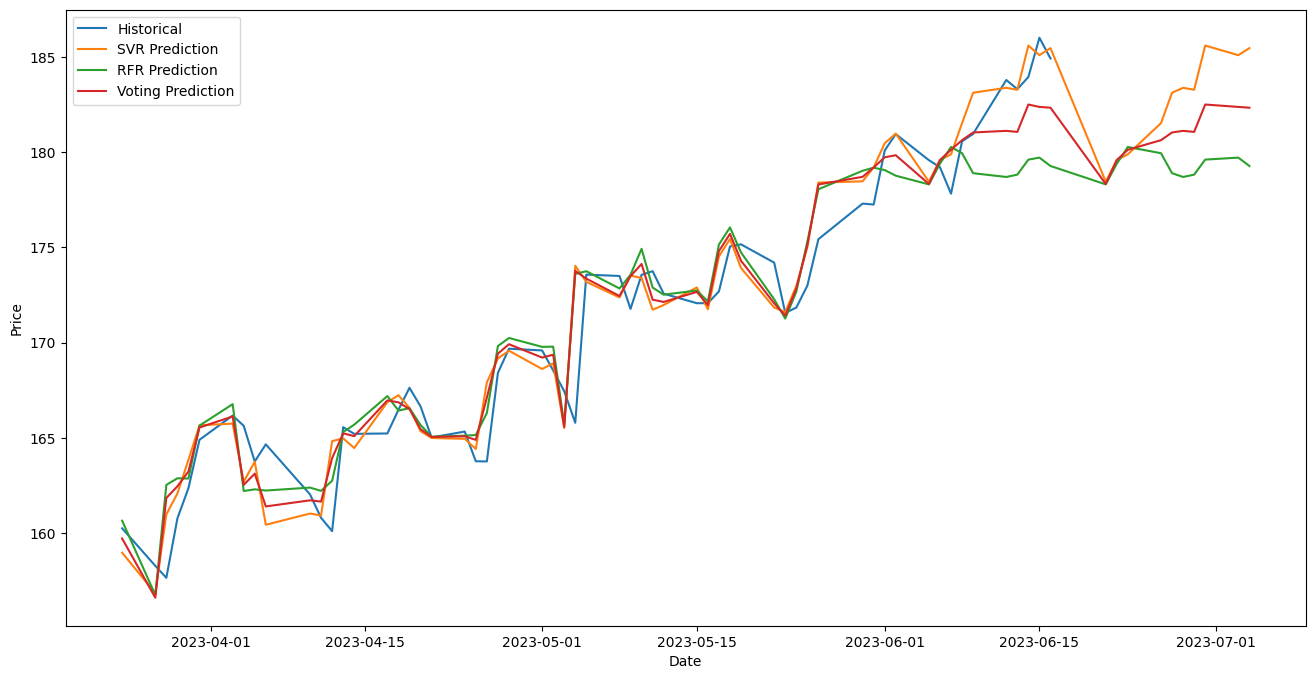

In [22]:
# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined2.index, df_combined2['Close'], label='Historical')
plt.plot(df_combined2.index,
        df_combined2['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined2.index,
        df_combined2['RFR Prediction'], label='RFR Prediction')
plt.plot(df_combined2.index,
        df_combined2['Voting Prediction'], label='Voting Prediction')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Displaying Forecasted Prices from all models

In [23]:
# Assuming df_forecast is your DataFrame
table = tabulate(df_forecast, headers='keys', tablefmt='fancy_grid')
print(table)


╒═════════════════════╤══════════════════╤══════════════════╤═════════════════════╕
│                     │   SVR Prediction │   RFR Prediction │   Voting Prediction │
╞═════════════════════╪══════════════════╪══════════════════╪═════════════════════╡
│ 2023-06-21 00:00:00 │          178.451 │          178.309 │             178.329 │
├─────────────────────┼──────────────────┼──────────────────┼─────────────────────┤
│ 2023-06-22 00:00:00 │          179.591 │          179.396 │             179.588 │
├─────────────────────┼──────────────────┼──────────────────┼─────────────────────┤
│ 2023-06-23 00:00:00 │          179.888 │          180.273 │             180.126 │
├─────────────────────┼──────────────────┼──────────────────┼─────────────────────┤
│ 2023-06-26 00:00:00 │          181.526 │          179.945 │             180.63  │
├─────────────────────┼──────────────────┼──────────────────┼─────────────────────┤
│ 2023-06-27 00:00:00 │          183.123 │          178.897 │             18

In [24]:
import plotly.graph_objects as go

# Create traces
trace_actual = go.Scatter(
    x=df_combined2.index,
    y=df_combined2['Close'],
    mode='lines',
    name='Historical'
)

trace_svr = go.Scatter(
    x=df_combined2.index,
    y=df_combined2['SVR Prediction'],
    mode='lines',
    name='SVR Prediction'
)

trace_rfr = go.Scatter(
    x=df_combined2.index,
    y=df_combined2['RFR Prediction'],
    mode='lines',
    name='RFR Prediction'
)

trace_voting = go.Scatter(
    x=df_combined2.index,
    y=df_combined2['Voting Prediction'],
    mode='lines',
    name='Voting Prediction'
)

data = [trace_actual, trace_svr, trace_rfr, trace_voting]

# Create layout
layout = go.Layout(
    title='Actual Price and Predictions',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


In [25]:
import pickle

with open('../fyp_project/dashboard/models/apple/rfr.pkl', 'wb') as f:
    pickle.dump(rfr_model, f)

with open('../fyp_project/dashboard/models/apple/svr.pkl', 'wb') as f:
    pickle.dump(svr_model, f)

with open('../fyp_project/dashboard/models/apple/voting.pkl', 'wb') as f:
    pickle.dump(voting_model, f)

with open('../fyp_project/dashboard/models/apple/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

df.to_csv('../fyp_project/dashboard/models/apple/df.csv', index=True)
X.to_csv('../fyp_project/dashboard/models/apple/X.csv', index=True)